In [1]:
# Importando bibliotecas necessárias

from pyspark.sql import SparkSession
from time import time
import pandas as pd
import os

In [ ]:
# PATH
def load_env_from_path(path):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"O arquivo {path} não foi encontrado.")
    
    with open(path) as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value
                
                # Caminho para o arquivo .env dentro da pasta .venv
env_path = '.venv/.env'
load_env_from_path(env_path)

# Agora você pode acessar as variáveis de ambiente
silver = os.getenv('SILVER')

In [2]:
# Iniciar a sessão Spark
spark = spark = (
    SparkSession.builder.appName("teste_performance")
    .config("spark.driver.memory", "16g")
    .config("spark.executor.memory", "16g")
    .config("spark.sql.session.timeZone", "America/Sao_Paulo")
    .config("spark.executor.cores", "4")
    .config("spark.default.parallelism", "100")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.task.cpus", "1")
    .getOrCreate()
)

# Carregar um DataFrame com dados para testar
df = spark.read.parquet("silver", header=True, inferSchema=True)
df.createOrReplaceTempView("DF")

24/09/16 17:40:22 WARN Utils: Your hostname, kleuber-IdeaPad-Gaming-3-15IMH05 resolves to a loopback address: 127.0.1.1; using 192.168.0.8 instead (on interface wlp0s20f3)
24/09/16 17:40:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/16 17:40:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/16 17:40:28 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [3]:
num_linhas = df.count()
print(f"O DataFrame tem {num_linhas} linhas.")

O DataFrame tem 23689584 linhas.


In [4]:
num_particoes = df.rdd.getNumPartitions()
print(f"O DataFrame tem {num_particoes} partições.")

O DataFrame tem 1014 partições.


In [5]:


def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            file_path = os.path.join(dirpath, file)
            total_size += os.path.getsize(file_path)
    return total_size

folder_path = '/home/kleuber/LAKE/silver/rainfall'
size_bytes = get_folder_size(folder_path)
print(f"O tamanho dos dados é {size_bytes / (1024 * 1024):.2f} MB")


O tamanho dos dados é 853.74 MB


In [6]:
# Criando listas para armazenar os tempos de execução
df_times = []
sql_times = []

# Executando 60 vezes
for _ in range(60):
    # Limpar cache antes de cada execução
    spark.catalog.clearCache()

    # Usando a API DataFrame
    start_time = time()
    df.groupBy("AAAAMM").agg({"PRECIPITACAO": "sum", "TEMPERATURA_AR": "sum"}).collect()
    df_time = time() - start_time
    df_times.append(df_time)

    # Usando Spark SQL
    start_time = time()
    spark.sql("""
        SELECT AAAAMM, SUM(PRECIPITACAO) AS PRECIPITACAO, SUM(TEMPERATURA_AR) AS TEMPERATURA_AR 
        FROM DF 
        GROUP BY AAAAMM
    """).collect()
    sql_time = time() - start_time
    sql_times.append(sql_time)

# Criando um DataFrame com os resultados
result_df = pd.DataFrame({
    'time_api': df_times,
    'time_sql': sql_times
})

In [7]:
# Visualizando o dataframe criado

result_df

,time_api,time_sql
0,16.472235,13.265795
1,12.737309,12.292174
2,12.720970,11.596710
3,12.300119,12.129435
4,12.245481,10.735702
5,11.065532,11.269252
6,11.414622,11.562613
7,10.903474,11.537369
8,12.429662,13.376702
9,13.181108,11.819086


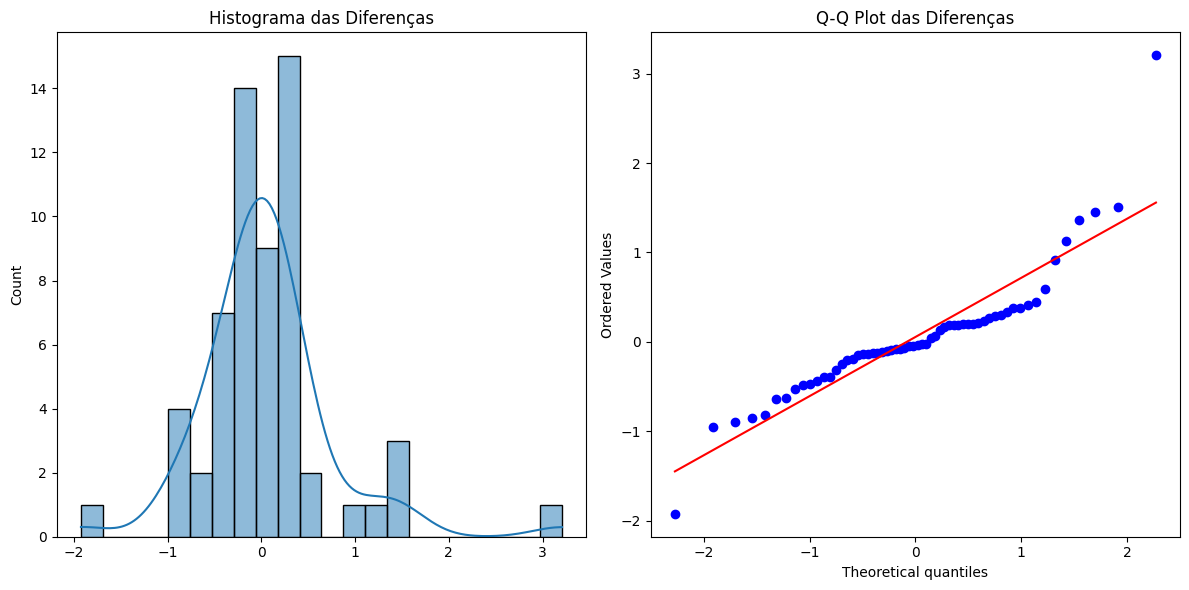

Estatística do teste de Shapiro-Wilk: 0.8607
Valor p: 0.0000
As diferenças não seguem uma distribuição normal.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro

# Calculando as diferenças entre os pares
differences = np.array(df_times) - np.array(sql_times)

# Visualizando a distribuição das diferenças
plt.figure(figsize=(12, 6))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(differences, kde=True)
plt.title('Histograma das Diferenças')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(differences, dist="norm", plot=plt)
plt.title('Q-Q Plot das Diferenças')

plt.tight_layout()
plt.show()

# Teste de normalidade
stat, p_value = shapiro(differences)
print(f'Estatística do teste de Shapiro-Wilk: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

if p_value < 0.05:
    print("As diferenças não seguem uma distribuição normal.")
else:
    print("As diferenças seguem uma distribuição normal.")


### Teste T pareado para comparação dos resultados

In [9]:
from scipy.stats import ttest_rel

# Realizando o teste t de Student para amostras emparelhadas
t_stat, p_value = ttest_rel(df_times, sql_times)

# Exibindo o resultado
print(f'Estatística t: {t_stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Definindo as hipóteses
print("\nHipóteses:")
print("Hipótese Nula (H0): As médias dos tempos de execução entre a API DataFrame e o Spark SQL são iguais.")
print("Hipótese Alternativa (H1): As médias dos tempos de execução entre a API DataFrame e o Spark SQL são diferentes.")

# Verificando o resultado
if p_value < 0.05:
    print("\nResultado:")
    print(f"Como o p-valor ({p_value}) é menor que o nível de significância de 5%, rejeitamos a hipótese nula. \nLogo, as médias são significativamente diferentes.")
else:
    print("\nResultado:")
    print(f"Como o p-valor ({p_value}) é maior ou igual ao nível de significância de 5%, não há evidências suficientes para rejeitar a hipótese nula.  \nLogo não há diferença significativa entre as médias.")


Estatística t: 0.6008
Valor p: 0.5503

Hipóteses:
Hipótese Nula (H0): As médias dos tempos de execução entre a API DataFrame e o Spark SQL são iguais.
Hipótese Alternativa (H1): As médias dos tempos de execução entre a API DataFrame e o Spark SQL são diferentes.

Resultado:
Como o p-valor (0.5502593479864359) é maior ou igual ao nível de significância de 5%, não há evidências suficientes para rejeitar a hipótese nula.  
Logo não há diferença significativa entre as médias.


In [10]:
from scipy.stats import wilcoxon

# Realizando o teste de Wilcoxon para amostras emparelhadas
stat, p_value = wilcoxon(df_times, sql_times)

# Exibindo o resultado
print(f'Estatística de Wilcoxon: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Definindo as hipóteses
print("\nHipóteses:")
print("Hipótese Nula (H0): As medianas dos tempos de execução entre a API DataFrame e o Spark SQL são iguais.")
print("Hipótese Alternativa (H1): As medianas dos tempos de execução entre a API DataFrame e o Spark SQL são diferentes.")

# Verificando o resultado
if p_value < 0.05:
    print("\nResultado:")
    print(f"Como o p-valor ({p_value}) é menor que o nível de significância de 5%, rejeitamos a hipótese nula. \nLogo, as medianas são significativamente diferentes.")
else:
    print("\nResultado:")
    print(f"Como o p-valor ({p_value}) é maior ou igual ao nível de significância de 5%, não há evidências suficientes para rejeitar a hipótese nula.  \nLogo não há diferença significativa entre as medianas.")



Estatística de Wilcoxon: 896.0000
Valor p: 0.8888

Hipóteses:
Hipótese Nula (H0): As medianas dos tempos de execução entre a API DataFrame e o Spark SQL são iguais.
Hipótese Alternativa (H1): As medianas dos tempos de execução entre a API DataFrame e o Spark SQL são diferentes.

Resultado:
Como o p-valor (0.8887623436669472) é maior ou igual ao nível de significância de 5%, não há evidências suficientes para rejeitar a hipótese nula.  
Logo não há diferença significativa entre as medianas.


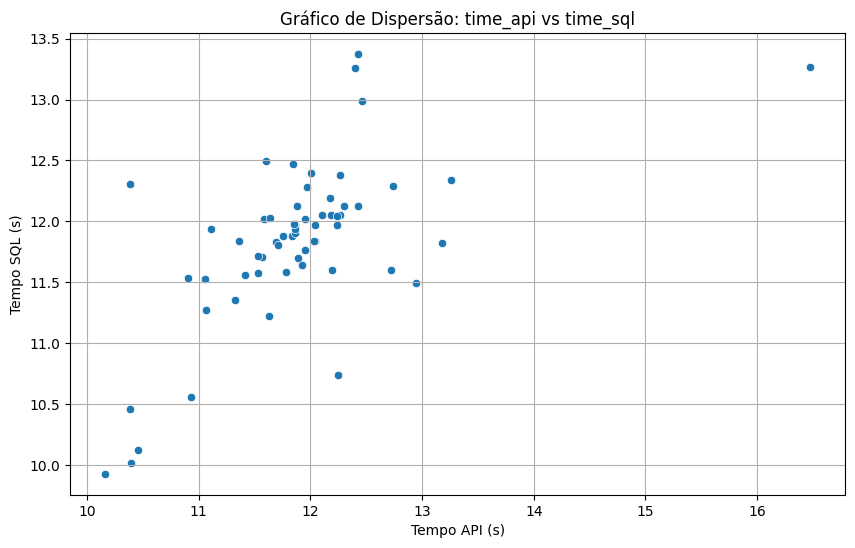

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='time_api', y='time_sql', data=result_df)
plt.title('Gráfico de Dispersão: time_api vs time_sql')
plt.xlabel('Tempo API (s)')
plt.ylabel('Tempo SQL (s)')
plt.grid(True)
plt.show()

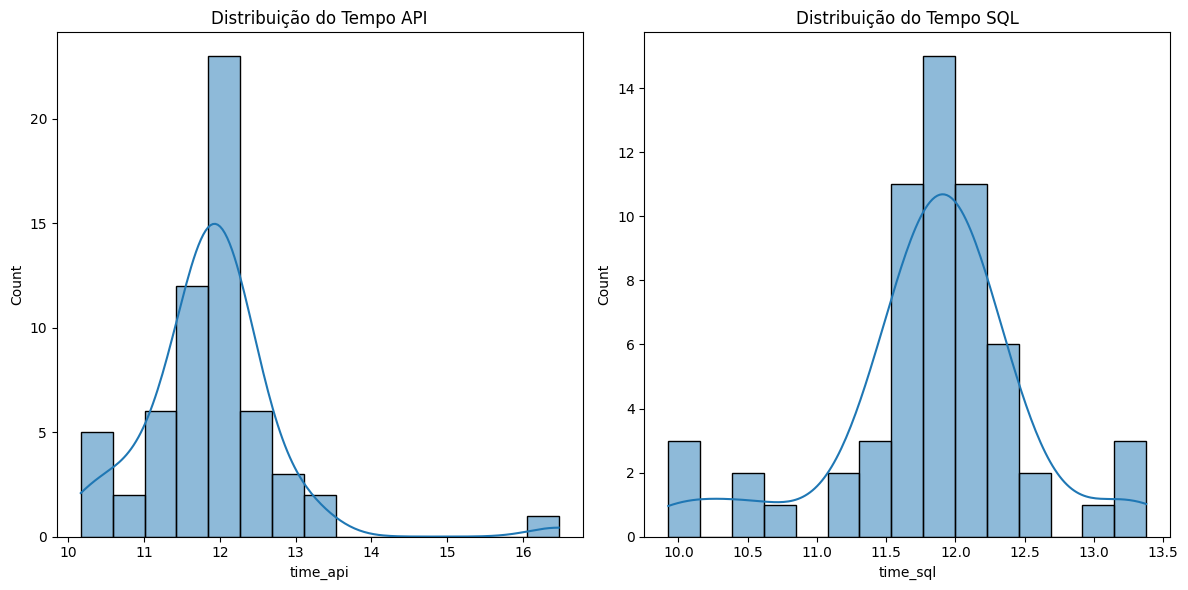

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(result_df['time_api'], kde=True, bins=15)
plt.title('Distribuição do Tempo API')

plt.subplot(1, 2, 2)
sns.histplot(result_df['time_sql'], kde=True, bins=15)
plt.title('Distribuição do Tempo SQL')

plt.tight_layout()
plt.show()


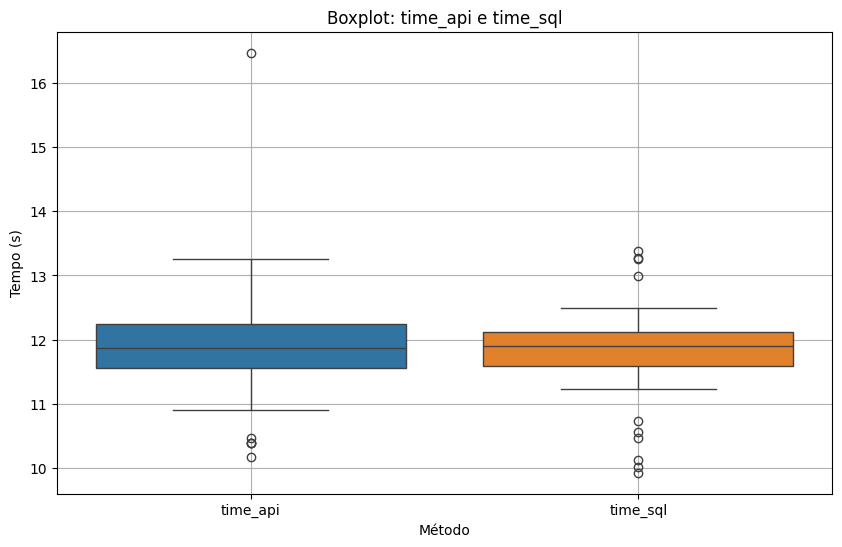

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=result_df)
plt.title('Boxplot: time_api e time_sql')
plt.xlabel('Método')
plt.ylabel('Tempo (s)')
plt.grid(True)
plt.show()


In [23]:
print("Estatísticas Descritivas:")
print(result_df.describe())

Estatísticas Descritivas:
        time_api   time_sql
count  60.000000  60.000000
mean   11.883409  11.828649
std     0.890139   0.678450
min    10.164215   9.927937
25%    11.555114  11.593451
50%    11.872428  11.893422
75%    12.237808  12.123705
max    16.472235  13.376702


In [25]:
cv_api = result_df['time_api'].std() / result_df['time_api'].mean() * 100
cv_sql = result_df['time_sql'].std() / result_df['time_sql'].mean() * 100

print(f"Coeficiente de Variação para time_api: {cv_api:.2f}%")
print(f"Coeficiente de Variação para time_sql: {cv_sql:.2f}%")

Coeficiente de Variação para time_api: 7.49%
Coeficiente de Variação para time_sql: 5.74%
